In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np


C:\Users\harno\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
BASE_DIR = "PlantVillage"
IMG_SIZE = 256 # check image proprties
BATCH_SIZE = 32 # standard convention 
EPOCH = 50 # at end of every epoch, we do validation
CHANNELS = 3
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=BASE_DIR, 
        shuffle=True, 
        image_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE
    )


Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
'''
Total images = 2152
Batch size = 32 
Total batches = 2152/32 = 68 = length of dataset
80% training data = 54 batches
10% validation data = 6 batches
10% testing data = 8 batches
'''
train_ds = dataset.take(54) #80% data is training
len(train_ds)

54

In [6]:
non_train_ds = dataset.skip(54)
val_ds = non_train_ds.take(6)
len(val_ds)

6

In [7]:
test_ds = non_train_ds.skip(6)
len(test_ds)

8

In [8]:
def get_ds_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    train_ds = ds.take(train_size)
    
    val_size = int(val_split*ds_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_ds_partitions(dataset)

In [10]:
'''
prefetch = CPU starts reading batch 2 even before GPU is done training on batch1.
cache = Not reading the same image again in epoch2 if it has already been read once in epoch1. 
'''
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
'''
Preprocessing
1. Rescale: The image pixel varies from a number 0 to 255. We need to divide each pixel by 255, such that they are between 0 and 1 only.
2. Resize: Similarly, we need to ensure all images are 256x256. Therefore, rescale the dataset. Although all our images are 256x256 but we still need to ensure.
3. Data augmentation: We create more data by rotating, flipping, changing contrast of existing data so our modls performs better.
'''
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1.0/255)
])
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [12]:
# CNN layers: Trial and eroor of alternating Conv2D and MaxPooling
n_classes = 3
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')    
])
model.build(input_shape=input_shape)

C:\Users\harno\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics = ['accuracy'])

In [15]:
history = model.fit(train_ds, epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 633ms/step - accuracy: 0.4648 - loss: 0.9445 - val_accuracy: 0.4375 - val_loss: 0.8785
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 638ms/step - accuracy: 0.6157 - loss: 0.7277 - val_accuracy: 0.5156 - val_loss: 1.0370
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 673ms/step - accuracy: 0.6983 - loss: 0.6484 - val_accuracy: 0.8177 - val_loss: 0.3795
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 618ms/step - accuracy: 0.8493 - loss: 0.3678 - val_accuracy: 0.8542 - val_loss: 0.3201
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 556ms/step - accuracy: 0.8957 - loss: 0.2777 - val_accuracy: 0.8906 - val_loss: 0.2479
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 557ms/step - accuracy: 0.9197 - loss: 0.1983 - val_accuracy: 0.8281 - val_loss: 0.4721
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 634ms/step - accuracy: 0.7600 - loss: 0.5955 - val_accuracy: 0.8542 - val_loss: 0.3077
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 593ms/step - accuracy: 0.9075 - loss: 0.2434 - val_accu

In [16]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9765 - loss: 0.0397


In [18]:
scores

[0.029580675065517426, 0.984375]

In [19]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [20]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


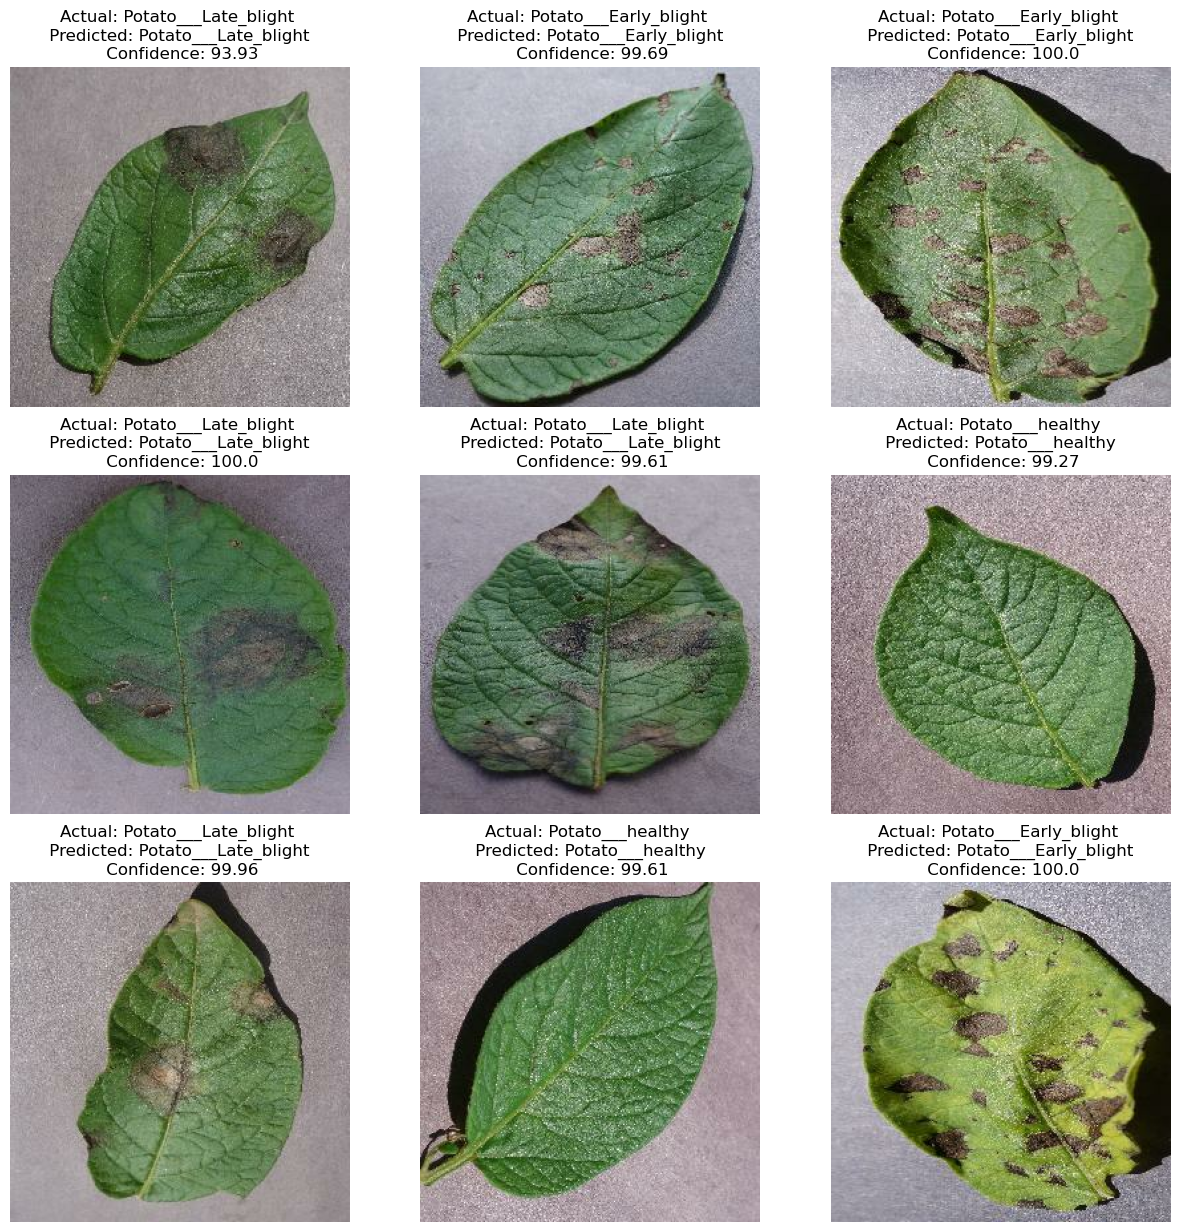

In [21]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}")
        plt.axis("off")

In [24]:
model_version=1
model.save(f"trained_model/{model_version}.keras")